<a href="https://colab.research.google.com/github/Randoot/Computer-Vision/blob/main/SemanticSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
---
# Image Segmentation
---
---

# Introduction to Image Segmentation

In this tutorial, we will use TensorFlow to perform semantic segmentation, classifying each pixel in an image into categories using a convolutional neural network (CNN). We'll follow a step-by-step guide to set up our environment, prepare data, train the model, and visualize the results.


## Dataset Overview

We will be using the Oxford-IIIT Pet Dataset for this tutorial, which includes images of 37 different pet breeds. Each image is annotated with a pixel-level mask that indicates three classes:
- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

These annotations are crucial for training our segmentation model to accurately distinguish between the pet and its surroundings.


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
import os

# Set the random seed for reproducibility ( to keep getting the same  results)
random.seed(42)
np.random.seed(42)
##  Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(42)
tf.random.set_seed(42)

# Loading our data.

- It loads the dataset using tfds.load.
- Defines a preprocess function to resize both the images and masks to 128x128 pixels and normalizes the image data.
- Applies this preprocessing function to both the training and testing datasets.
- Organizes the data into batches (which is useful for training) and uses prefetch to improve performance during training by reducing waiting time during model training iterations.

In [ ]:
# Load the Oxford-IIIT Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

# Function to preprocess the images and masks
def preprocess(image, mask):
    image = tf.image.resize(image, (128, 128))
    # When resizing, antialias might add artifacts to your images to soften the edges,
    # adding new colors that don't belong to any class in the label map. We can overcome this problem loading
    # (or decoding) input images with TensorFlow as PNG and resizing our images with TensorFlow's NEAREST_NEIGHBOR resizing method.
    mask = tf.image.resize(mask, (128, 128), method='nearest')
    # Normalize the image
    image = tf.cast(image, tf.float32) / 255.0
    # Subtract 1 from the mask labels to have a range from 0 to 2 instead of 1 to 3
    mask -= 1
    return image, mask

# Prepare the training and testing datasets
train_dataset = dataset['train'].map(lambda x: preprocess(x['image'], x['segmentation_mask']))
test_dataset = dataset['test'].map(lambda x: preprocess(x['image'], x['segmentation_mask']))

# Batch and prefetch the data for optimal performance
train_dataset = train_dataset.batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

print("Data loaded and preprocessed successfully!")

Data loaded and preprocessed successfully!


# visualizing our training data
## Create a Function to Display Images and Masks
You can create a function to display a batch of images alongside their corresponding masks. This function will help you quickly check multiple samples from your dataset.

In [ ]:
import matplotlib.pyplot as plt

def display_sample(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        # Check if the image has less than 3 dimensions and adjust accordingly
        if len(display_list[i].shape) < 3:
            plt.imshow(display_list[i], cmap='gray')  # Use a grayscale colormap
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))

        plt.axis('off')
    plt.show()


## Show Images and Masks from the Dataset
You can now use the function to display images and their corresponding masks from the dataset. Since the model training hasn't started yet, we'll display the true masks without the predicted masks.

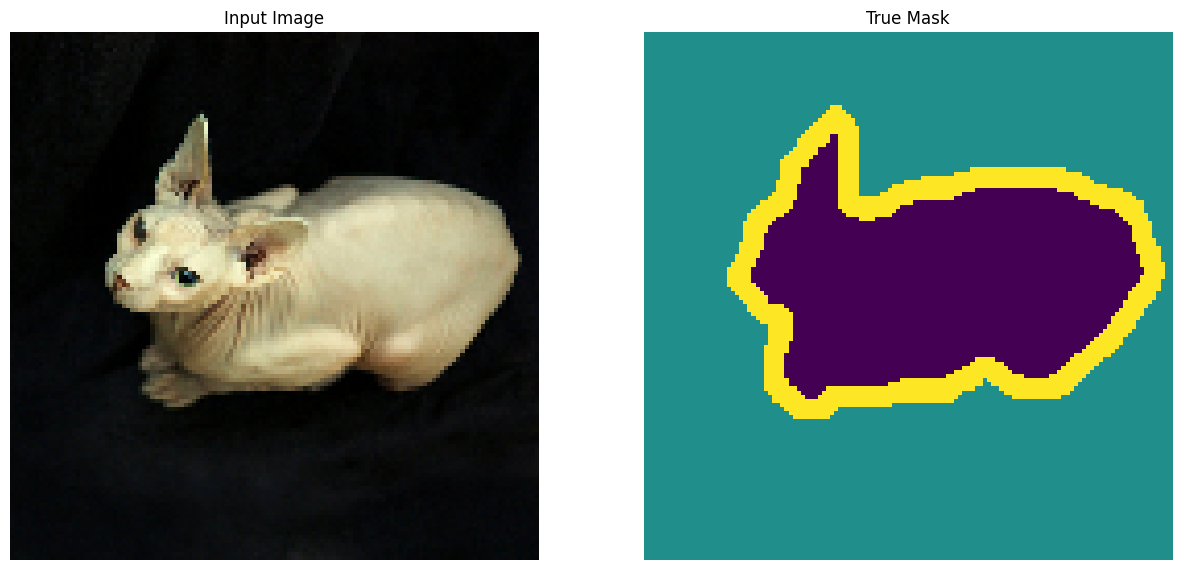

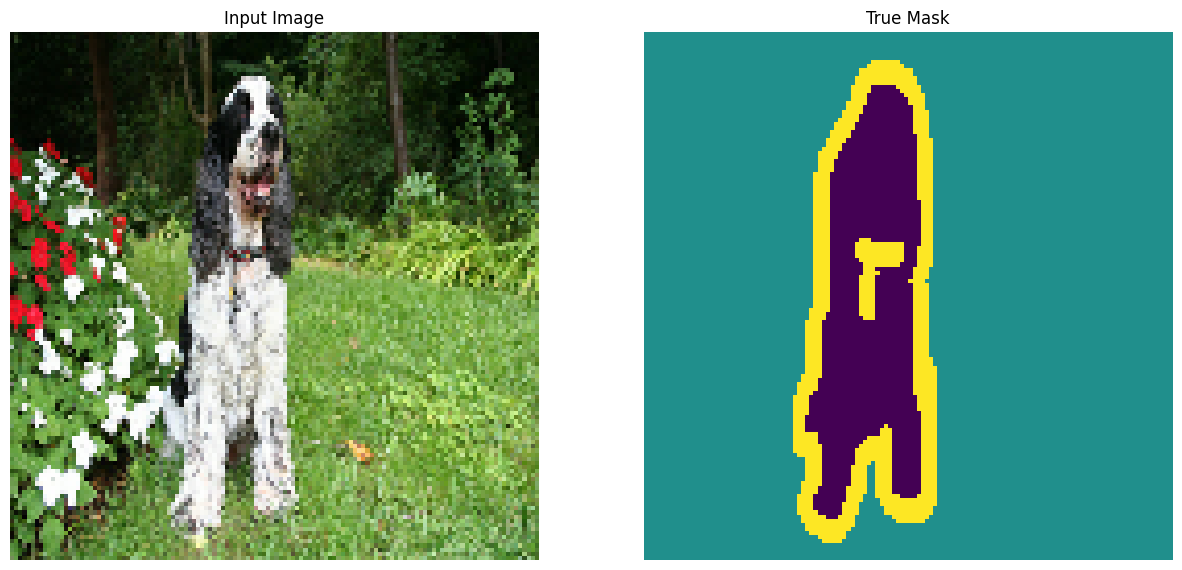

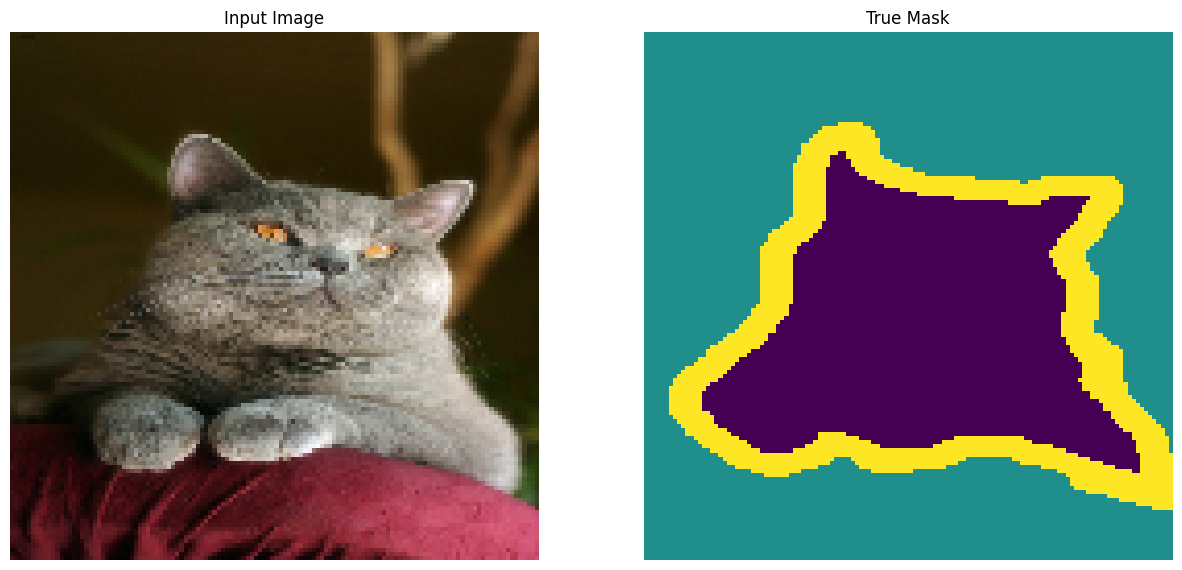

In [ ]:
# Take one batch from the training dataset
for images, masks in train_dataset.take(1):
    for i in range(3):  # Display the first 3 images and masks from the batch
        sample_image, sample_mask = images[i], masks[i]
        display_sample([sample_image, sample_mask])



# Defining the Model
Here’s how you can define a simple U-Net model using TensorFlow's Keras API. You can paste the following code into the next cell of your Google Colab notebook:

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.models import Model
from keras import Input

def unet_model(output_channels):
  inputs = Input(shape=[128,128,3])

  #1
  x = Conv2D(64, 3, activation= 'relu', padding='same')(inputs)
  x = Conv2D(64, 3, activation= 'relu', padding='same')(x)
  x1 = MaxPooling2D()(x)

  #2
  x = Conv2D(128, 3, activation= 'relu', padding='same')(x1)
  x = Conv2D(128, 3, activation= 'relu', padding='same')(x)
  x2 = MaxPooling2D()(x)

  #3
  x = Conv2D(256, 3, activation= 'relu', padding='same')(x2)
  x = Conv2D(256, 3, activation= 'relu', padding='same')(x)
  x3 = MaxPooling2D()(x)

  x = Conv2DTranspose(256, 2, strides = 2, activation = 'relu', padding = 'same')(x3)
  x = concatenate([x, x2])
  x = Conv2D(256, 3, activation='relu', padding='same')(x)
  x = Conv2D(256, 3, activation='relu', padding='same')(x)

  x = Conv2DTranspose(128, 2, strides = 2, activation = 'relu', padding = 'same')(x3)
  x = concatenate([x, x1])
  x = Conv2D(128, 3, activation='relu', padding='same')(x)
  x = Conv2D(128, 3, activation='relu', padding='same')(x)

  x = Conv2DTranspose(64, 2, strides = 2, activation = 'relu', padding = 'same')(x3)
  x = concatenate([x, x2])
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)

  outputs = Conv2D(output_channels, 1, activation='softmax')(x)
  model = Model(inputs, outputs)
  return model

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.models import Model
from keras import Input

def unet_model(output_channels):
    inputs = Input(shape=[128, 128, 3])
    # Block 1
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x1 = MaxPooling2D()(x)

    # Block 2
    x = Conv2D(128, 3, activation='relu', padding='same')(x1)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x2 = MaxPooling2D()(x)

    # Block 3
    x = Conv2D(256, 3, activation='relu', padding='same')(x2)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x3 = MaxPooling2D()(x)

    x = Conv2DTranspose(256, 2, strides=2, activation='relu', padding='same')(x3)
    x = concatenate([x, x2])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(128, 2, strides=2, activation='relu', padding='same')(x)
    x = concatenate([x, x1])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(64, 2, strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)

    # Output layer
    outputs = Conv2D(output_channels, 1, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the model with the number of output channels equal to the number of classes (3 in this case)
model = unet_model(3)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        262,400 │ max_pooling2d_2[0][0]  │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 384)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        884,992 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 128)    │        131,200 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 64, 64, 192)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ max_pooling2d[0][0]    │
├──────────────────────

 Total params: 3,489,859 (13.31 MB)

 Trainable params: 3,489,859 (13.31 MB)

 Non-trainable params: 0 (0.00 B)

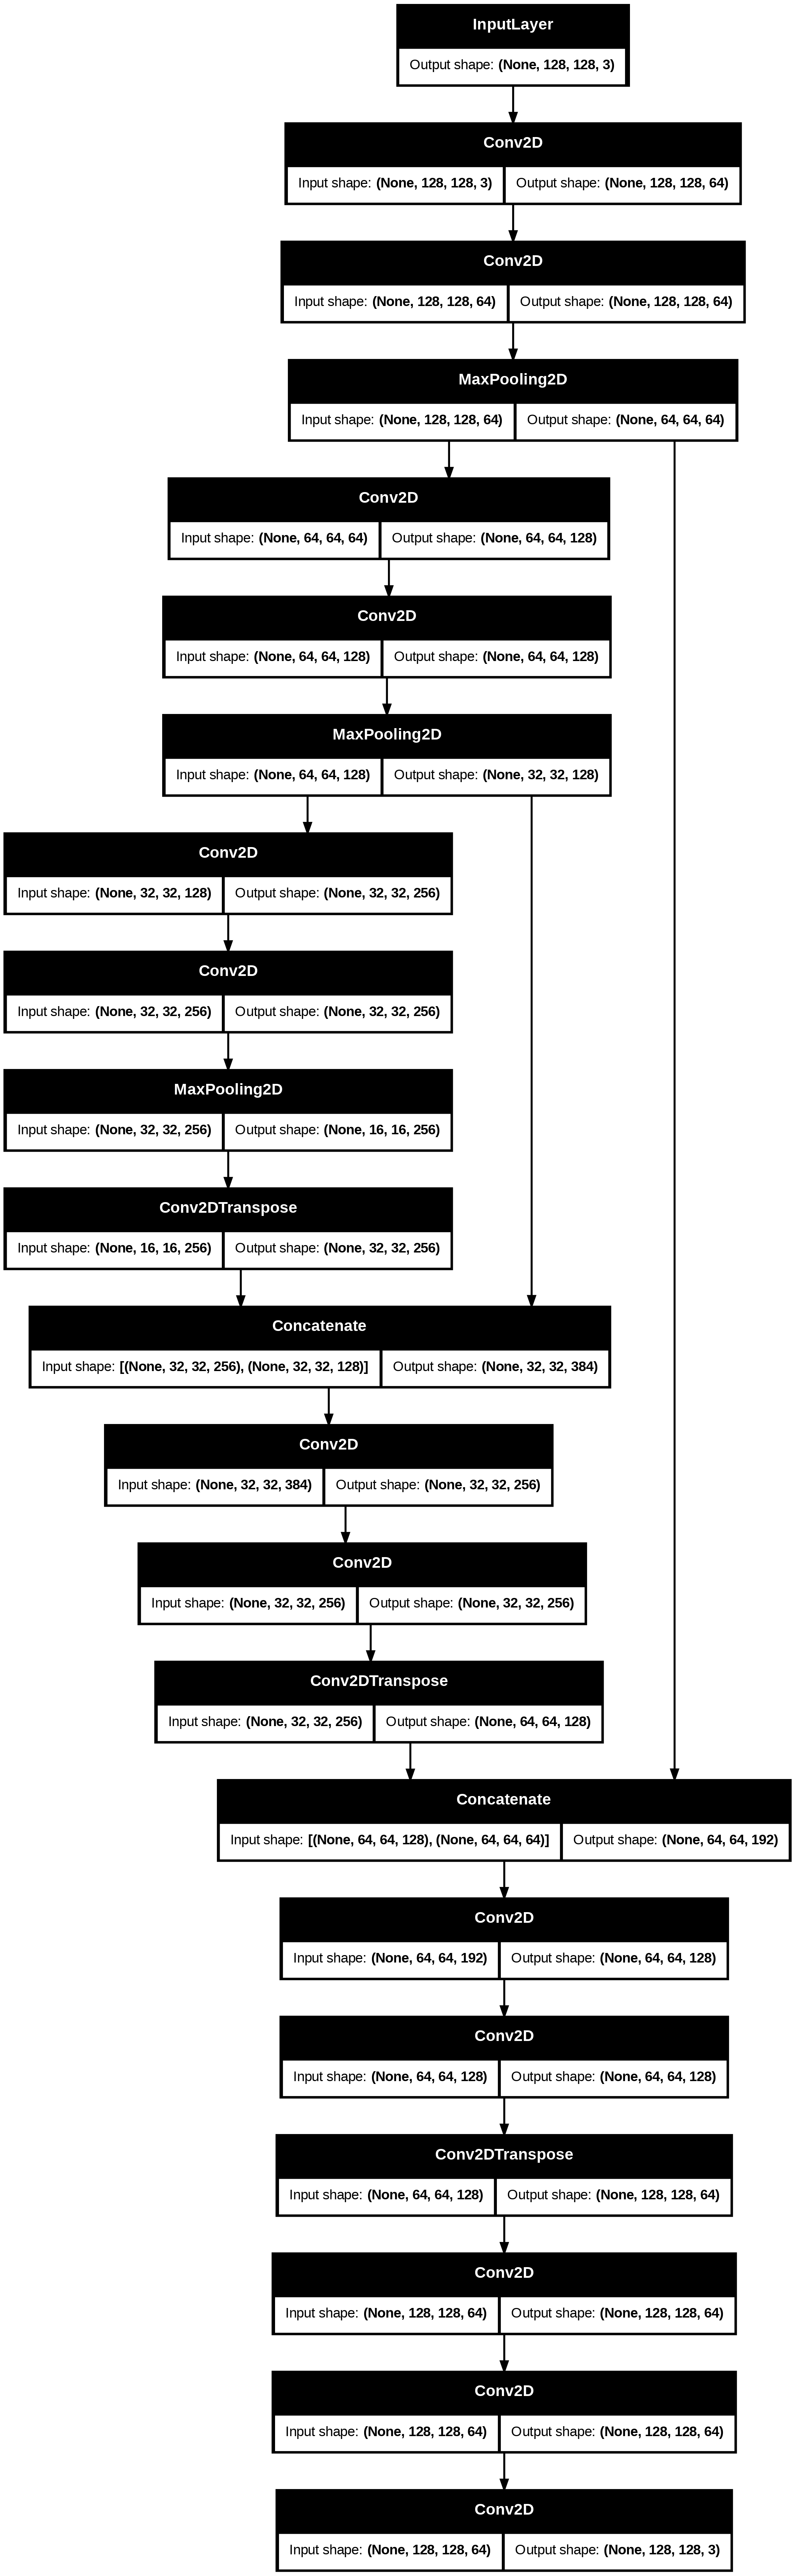

In [ ]:
from keras import utils
# Display the model's architecture
utils.plot_model(model, "CNN.png", show_shapes=True)

# Compile the Model
Once the model is defined, you need to compile it, specifying the optimizer, loss function, and metrics to use:

In [ ]:
# using the Adam optimizer and sparse categorical crossentropy as the loss function
# which is suitable for multi-class pixel-wise classification tasks like segmentation.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Model Training
With the model compiled, the next step would be to train it using your prepared datasets. This involves setting the number of epochs and optionally using callbacks like ModelCheckpoint or EarlyStopping for better training management.

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras', verbose = 1, save_best_only = True , monitor = 'val_accuracy')

history = model.fit(train_dataset, epochs =10,)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.5867 - loss: 1.1193
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 971ms/step - accuracy: 0.5877 - loss: 0.9164
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 958ms/step - accuracy: 0.5854 - loss: 0.8611
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 961ms/step - accuracy: 0.5877 - loss: 0.9079
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 973ms/step - accuracy: 0.6176 - loss: 0.7793
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 967ms/step - accuracy: 0.7101 - loss: 0.7001
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 970ms/step - accuracy: 0.7234 - loss: 0.6740
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 982ms/step - accuracy: 0.7179 - loss: 0.6787
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 983ms/step - accuracy: 0.7483 - loss: 0.6169
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 978ms/step - accuracy: 0.7556 - loss: 0.6042


Its the same as the previous code but with checkpoint

In [ ]:
from keras.callbacks import ModelCheckpoint

# Setup ModelCheckpoint to save the model at the epoch where it achieves the best validation accuracy
checkpoint = ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True, monitor='val_accuracy')

# Train the model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    callbacks=[checkpoint])

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.7751 - loss: 0.5622
Epoch 1: val_accuracy improved from -inf to 0.77885, saving model to best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7752 - loss: 0.5618 - val_accuracy: 0.7789 - val_loss: 0.5536
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.7607 - loss: 0.5973
Epoch 2: val_accuracy improved from 0.77885 to 0.79108, saving model to best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7609 - loss: 0.5969 - val_accuracy: 0.7911 - val_loss: 0.5264
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.7941 - loss: 0.5210
Epoch 3: val_accuracy improved from 0.79108 to 0.79346, saving model to best_model.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7942 - loss: 0.5207 - val_accuracy: 0.7935 - val_loss: 0.5197
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.7580 - loss: 0.5979
Epoch 4: val_accuracy did not improve from 0.79

# Undertsanding the design of the above CNN

The neural network is a U-Net structure, which is a type of convolutional neural network that is particularly effective for tasks like image segmentation, where the goal is not just to classify an entire image but to classify each pixel of the image. U-Net is designed to work well with fewer training samples and to produce precise segmentations.

### U-Net Model Structure:

1. **Input Layer:**
   - Takes an image of size 128x128 pixels with 3 color channels (RGB).

2. **Contracting Path (Downsampling):**
   - Features are extracted and compressed through layers of convolution (`Conv2D`) and spatial dimension reduction (`MaxPooling2D`), increasing the filter count (64, 128, 256) to capture information at different scales.

3. **Expansive Path (Upsampling):**
   - The spatial dimensions of the feature maps are increased using `Conv2DTranspose` layers.
   - Upsampled maps are merged with corresponding feature maps from the downsampling path via concatenation to restore spatial details lost during downsampling.
   - Further refined by additional convolution layers.

4. **Output Layer:**
   - A final convolution (`Conv2D`) with a 1x1 filter adjusts the depth to match the number of output classes (3 in this case), using `softmax` activation for pixel classification.

### Rationale:

- **Skip Connections:** Critical for adding fine-grained details to the output, enhancing accuracy in pixel-level segmentation.
- **Transposed Convolution:** Aids in reconstructing the output to the original image size, ensuring detailed and accurate segmentation.

U-Net is effective for tasks needing precise localization and detailed context, such as medical image analysis and satellite image processing.


# Visualizing our output
## Generate Predictions
First, you need to generate predictions for a batch of images from your dataset. Let's write a function to make predictions and then visualize them:

(128, 128, 128, 3)
(128, 128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
(128, 128, 128, 3)


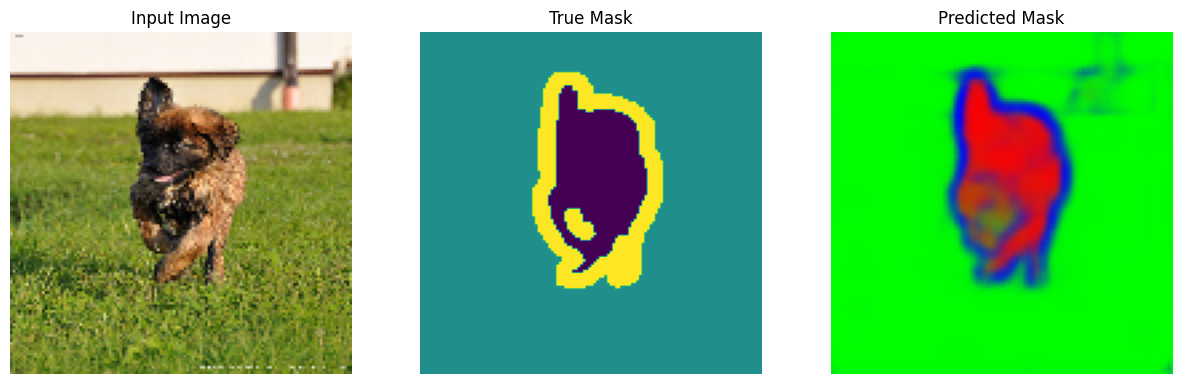

In [ ]:
for images, masks in test_dataset.take(1):
  print(images.shape)
  print(masks.shape)
  p = model.predict(test_dataset.take(1))
  print(p.shape)
  display_sample([images[0], masks[0], p[0]])

In [ ]:
import numpy as np

def show_predictions(model=None, dataset=None, num=1):
    if dataset and model:
        for images, masks in dataset.take(num):
            preds = model.predict(images)
            for i in range(num):
                display_sample([images[i], masks[i], preds[i]])


In [ ]:
import numpy as np

def show_presictions(model= None, dataset=None, num= 1):
  if dataset and model:
    for images, masks in dataset.take(num):
      preds = model.predict(images)
      for i in range(num):
        display_sample([images[i], masks[i], preds[i]])

# Display Sample Images with Predictions
Now you can use this function to display the images along with their true and predicted masks. You can specify how many examples you want to see:

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step


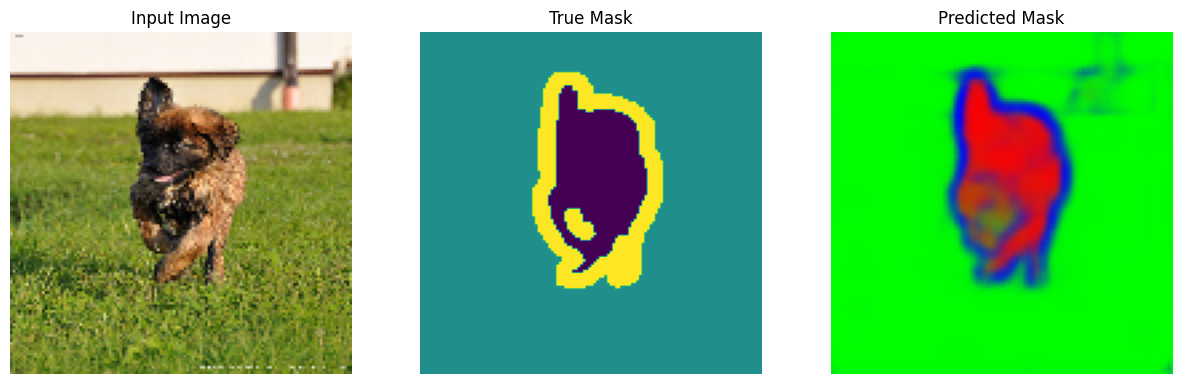

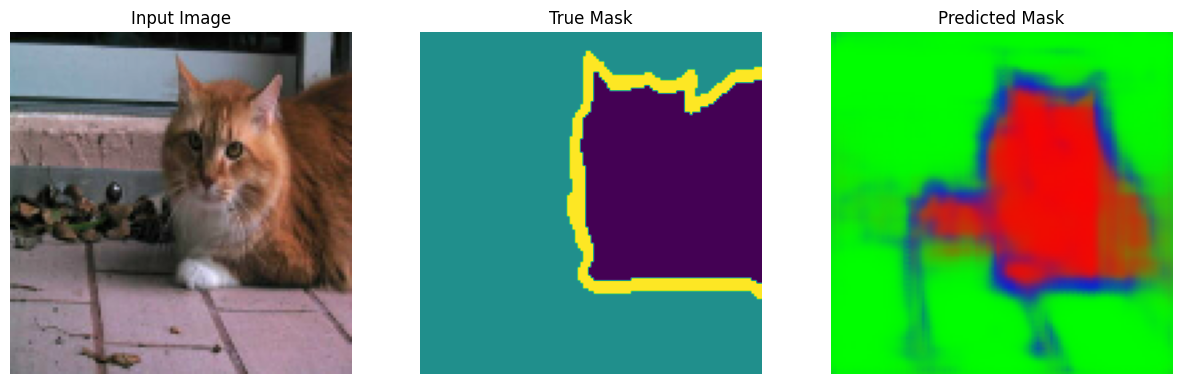

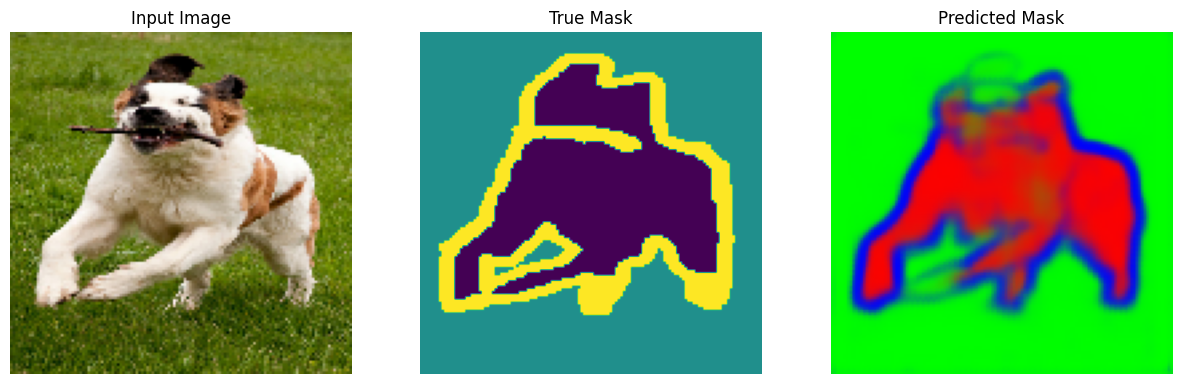

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


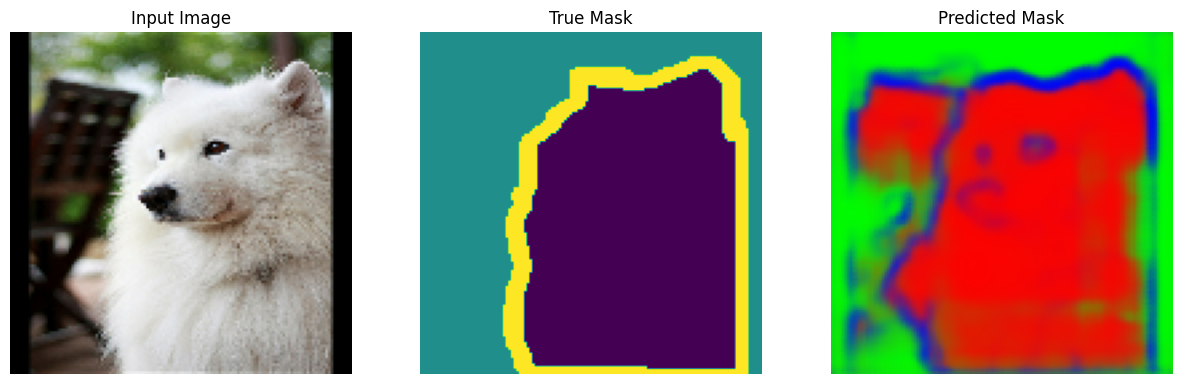

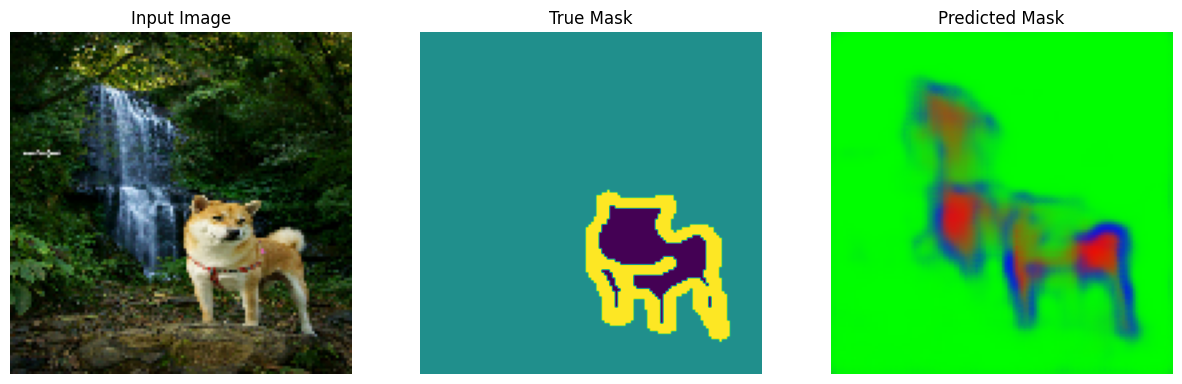

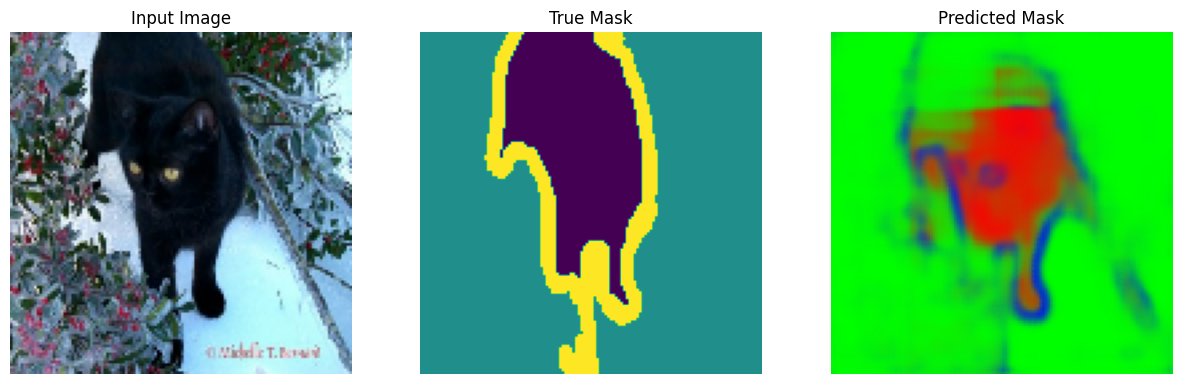

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


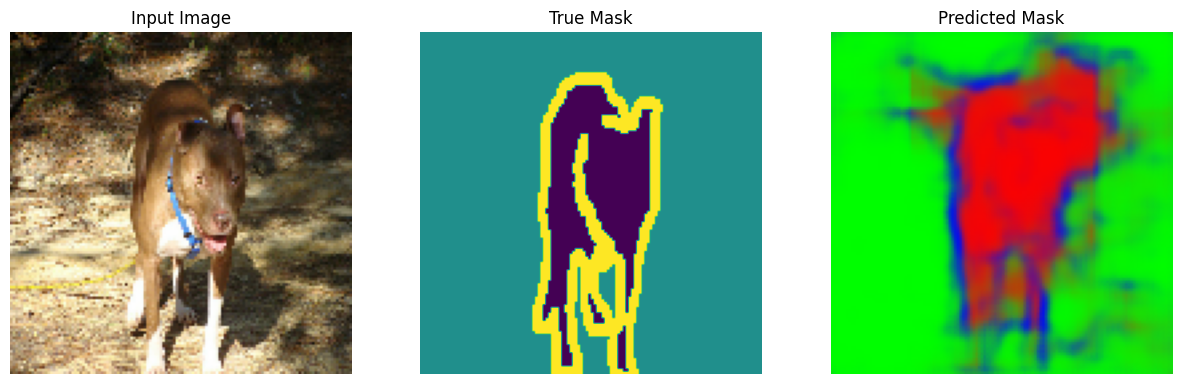

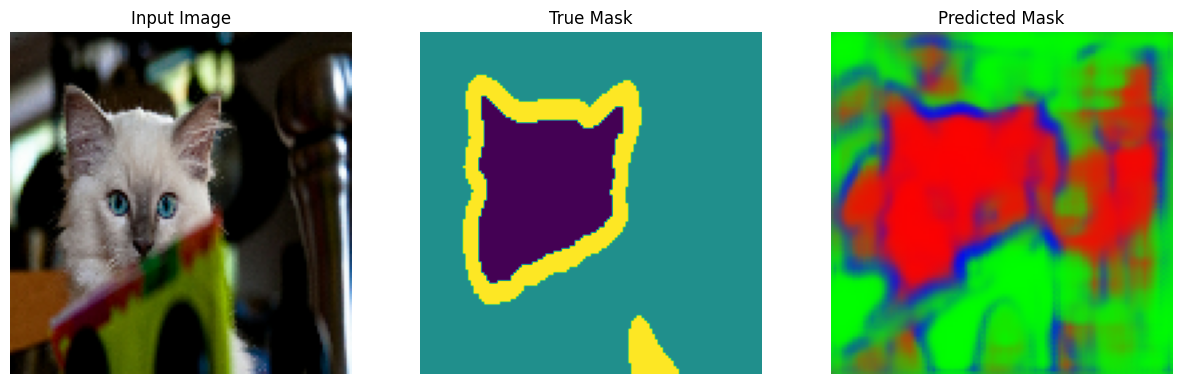

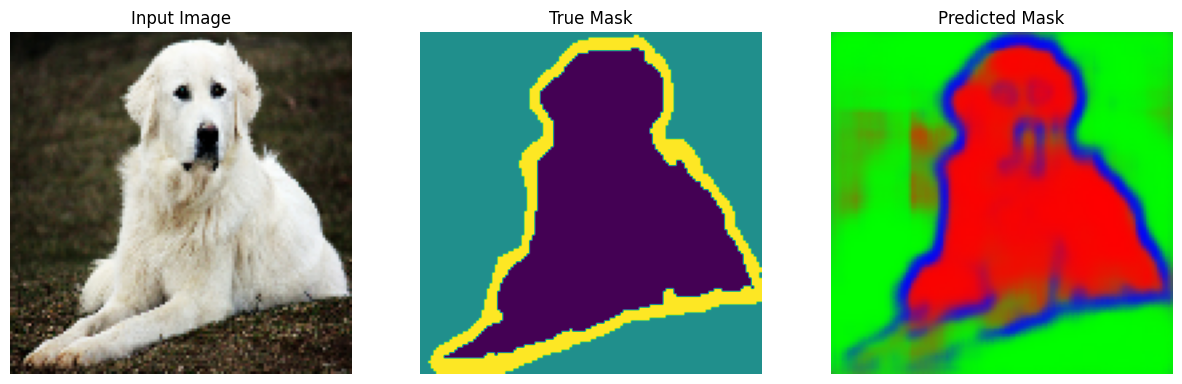

In [ ]:
# Displaying 3 sample predictions from the test dataset
show_presictions(model, test_dataset, 3)

# Choosing a Pretrained Model
For image segmentation, a popular choice is to use a pretrained model like MobileNetV2 or ResNet as the backbone for a U-Net architecture. These models are widely used due to their robustness and efficiency in extracting useful features from images.

# Integrating a Pretrained Model with U-Net
Let’s go through how to integrate a pretrained MobileNetV2 model with a U-Net architecture in TensorFlow.

In [ ]:
import tensorflow as tf
from keras import layers, models

# Load the pretrained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Freeze the pretrained layers
base_model.trainable = False

# Create the U-Net model
inputs = tf.keras.Input(shape=[128, 128, 3])
x = base_model(inputs, training=False)  # Ensure base model is in inference mode
x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)

outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
model_pretrained = models.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top = False)
base_model.trainable = False

inputs = tf.keras.Input(shape= [128,128,3])
x = base_model(inputs, training = False)
x= layers.Conv2DTranspose(256, 3, strides = 2 , padding = 'same', activation = 'relu')(x)
x= layers.Conv2DTranspose(256, 3, strides = 2 , padding = 'same', activation = 'relu')(x)
x= layers.Conv2DTranspose(128, 3, strides = 2 , padding = 'same', activation = 'relu')(x)
x= layers.Conv2DTranspose(128, 3, strides = 2 , padding = 'same', activation = 'relu')(x)
x= layers.Conv2DTranspose(64, 3, strides = 2 , padding = 'same', activation = 'relu')(x)

outputs = layers.Conv2D(1,1,activation= 'sigmoid')(x)
model_pretrained = models.Model(inputs, outputs)

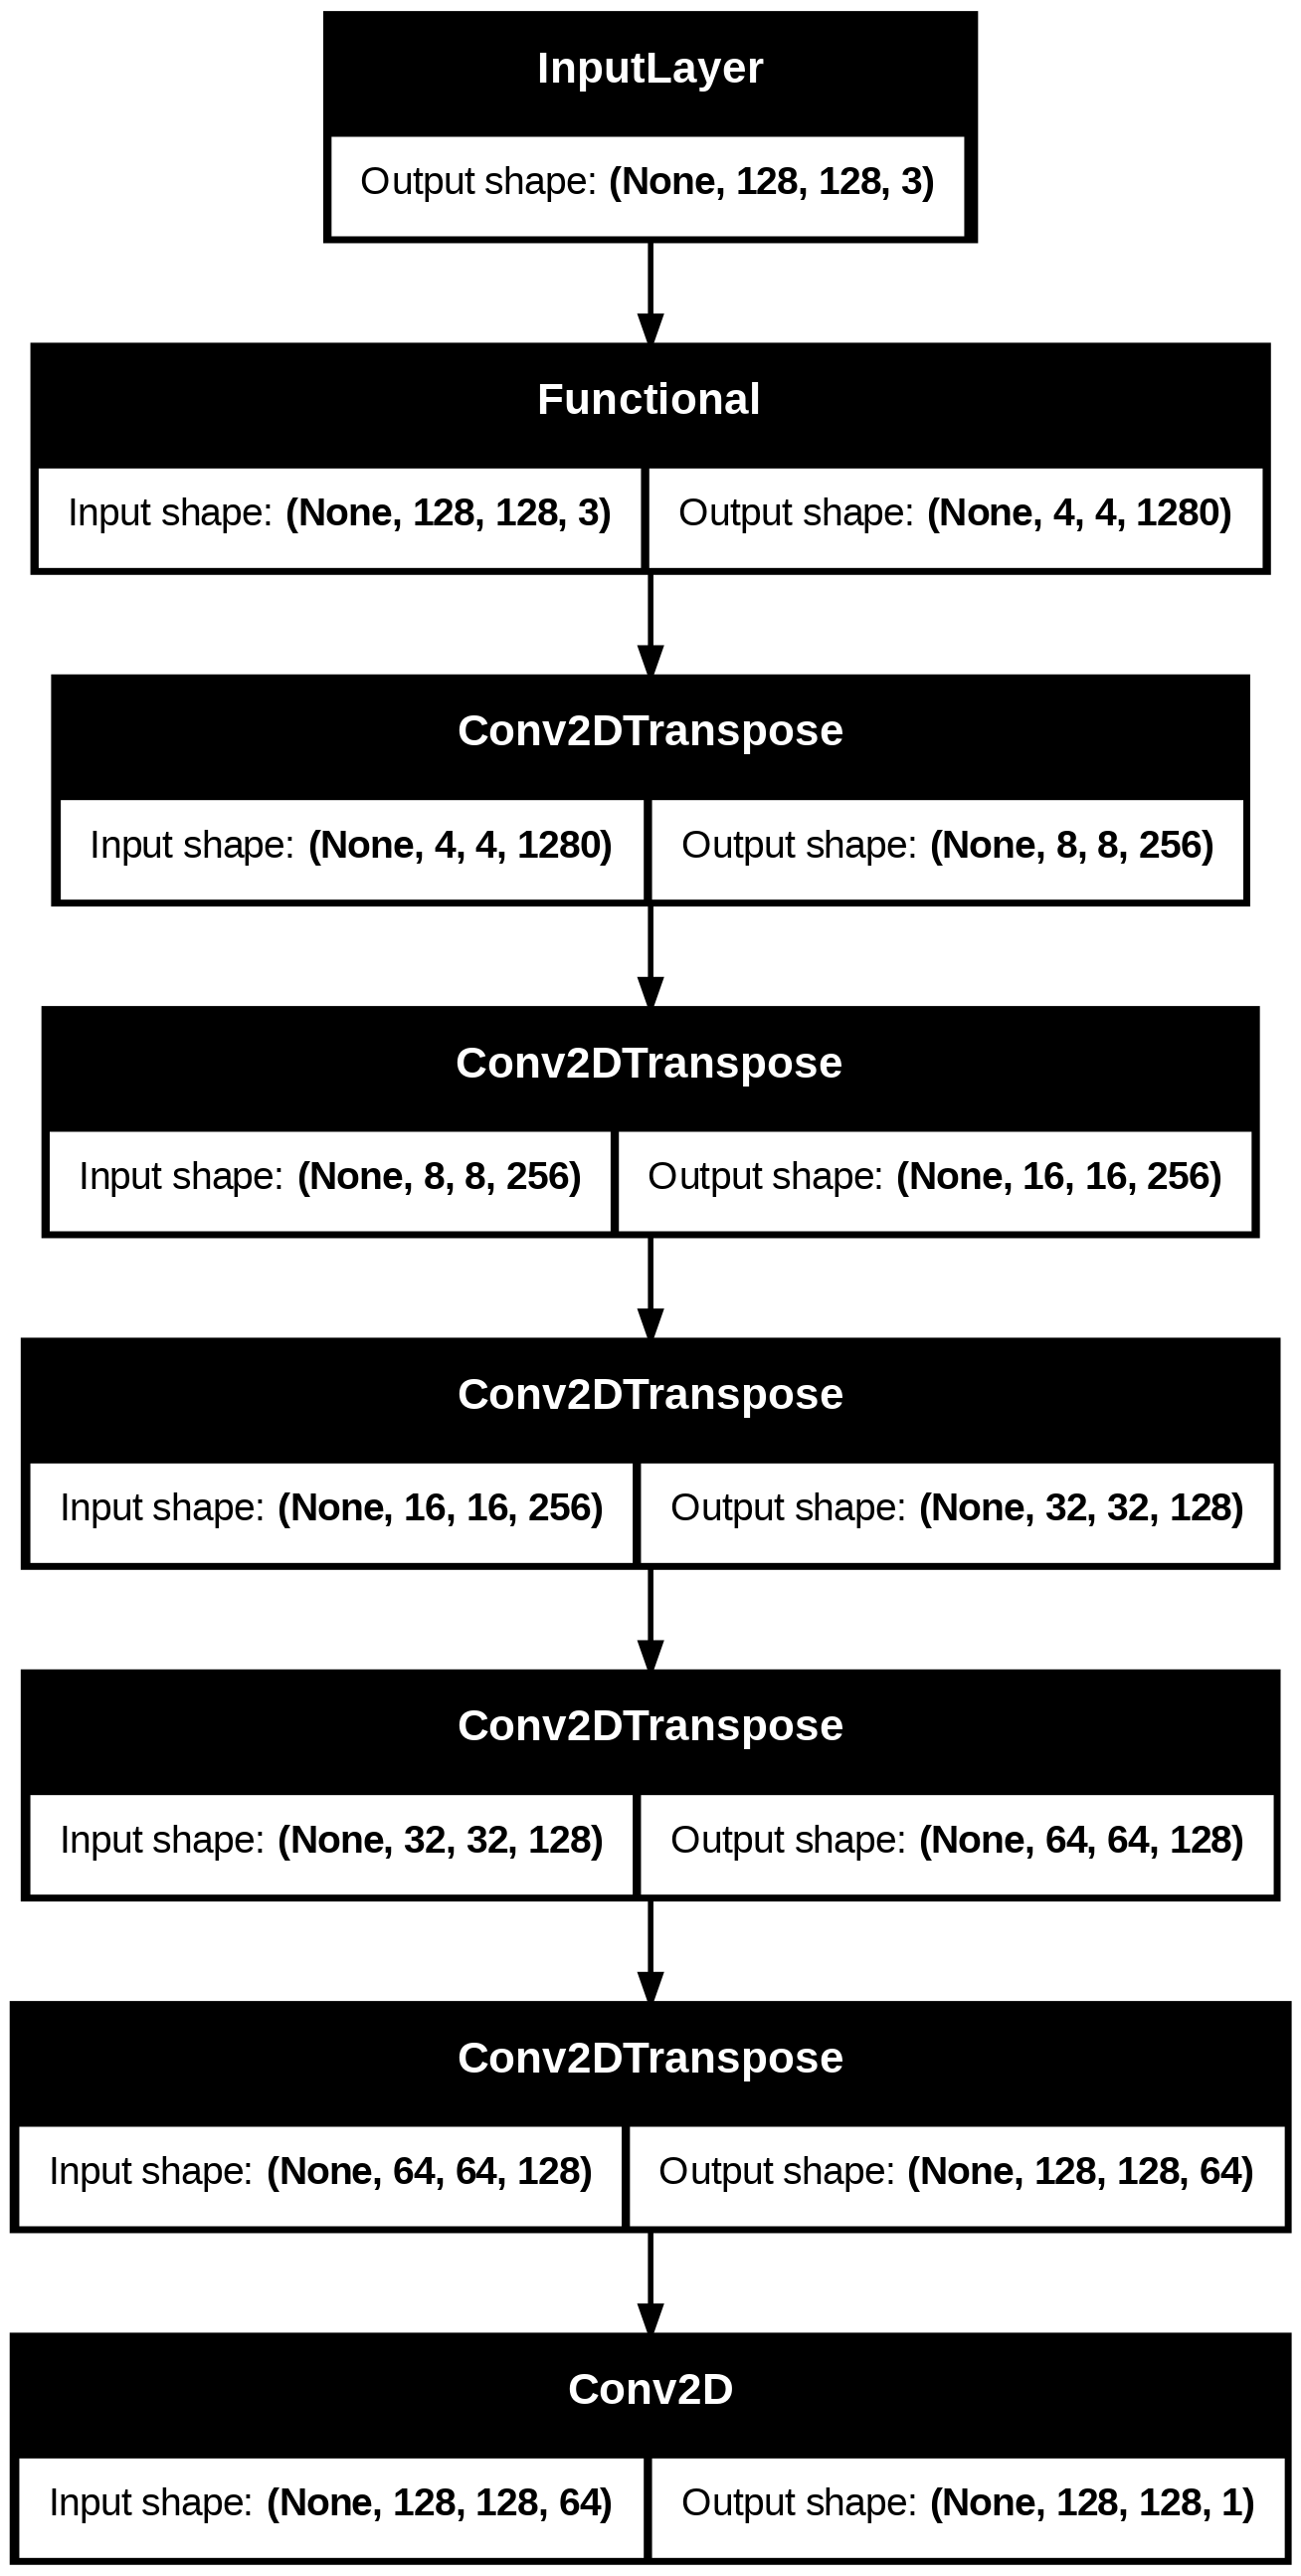

In [ ]:
from keras import utils
# Display the model's architecture
utils.plot_model(model_pretrained, "pretrained.png", show_shapes=True)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Compile the model
model_pretrained.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Setup ModelCheckpoint to save the model at the epoch where it achieves the best validation accuracy
checkpoint = ModelCheckpoint('best_model_pretrained.keras', verbose=1, save_best_only=True, monitor='val_accuracy')

# Continue training for fine-tuning
history_fine = model_pretrained.fit(train_dataset, epochs=35, validation_data=test_dataset, callbacks=[checkpoint, early_stopping])

Epoch 1/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5721 - loss: 0.6042   
Epoch 1: val_accuracy improved from -inf to 0.57723, saving model to best_model_pretrained.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.5724 - loss: 0.5999 - val_accuracy: 0.5772 - val_loss: -0.0504
Epoch 2/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5877 - loss: -70.7448
Epoch 2: val_accuracy did not improve from 0.57723
29/29 ━━━━━━━━━━━━━━━━━━━━ 66s 731ms/step - accuracy: 0.5877 - loss: -81.7145 - val_accuracy: 0.5772 - val_loss: -3553.0745
Epoch 3/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6245 - loss: -20857.0488
Epoch 3: val_accuracy improved from 0.57723 to 0.68348, saving model to best_model_pretrained.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6252 - loss: -22257.3652 - val_accuracy: 0.6835 - val_loss: -281159.3750
Epoch 4/35
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.6858 - loss: -737647.5000
Epoch 4: val_accuracy improv

In [ ]:
#### Optional Trial that may take a long time
# Unfreeze the entire model for fine-tuning
# base_model.trainable = True
# model_pretrained.summary(show_trainable=True)
# # Compile the model
# model_pretrained.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# # Continue training for fine-tuning
# history_fine = model_pretrained.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[checkpoint])

Now, we use the previous show_predictions(model, dataset, num) function to visualize our output.

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step


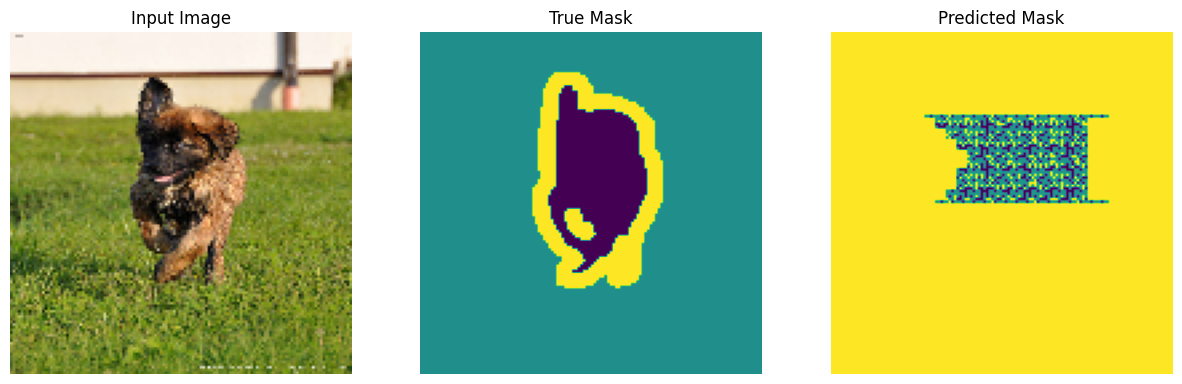

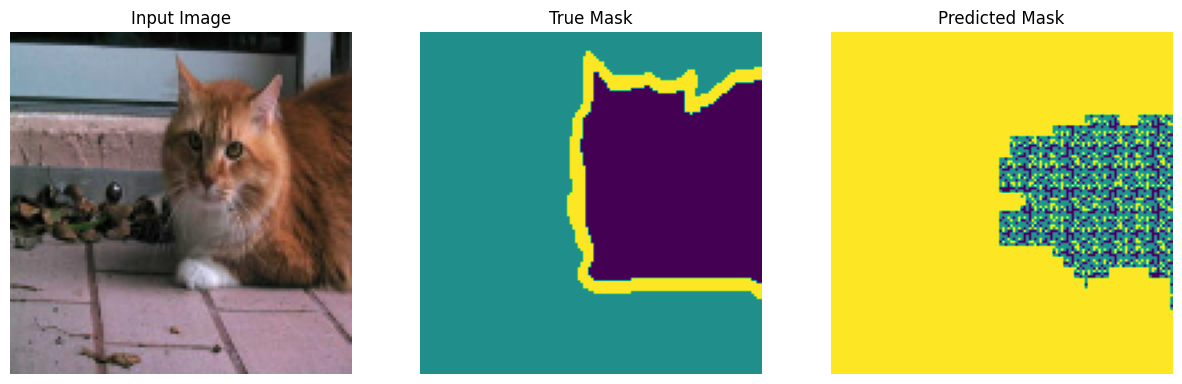

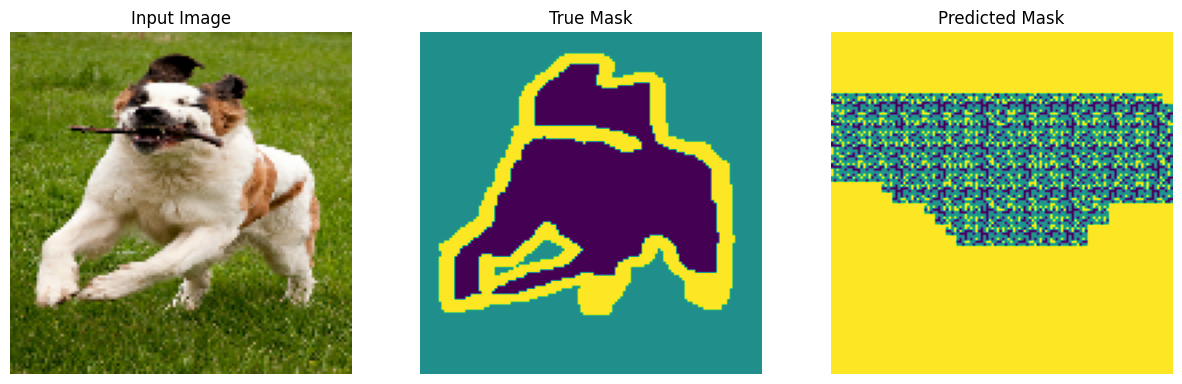

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


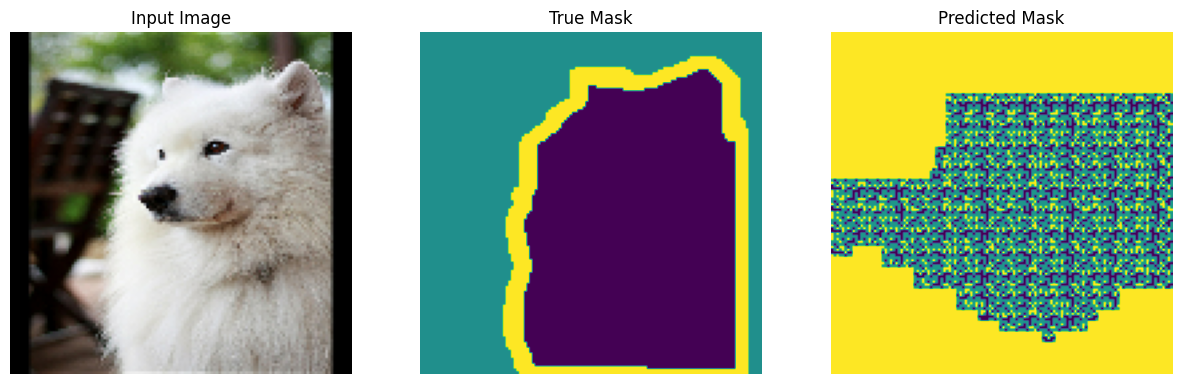

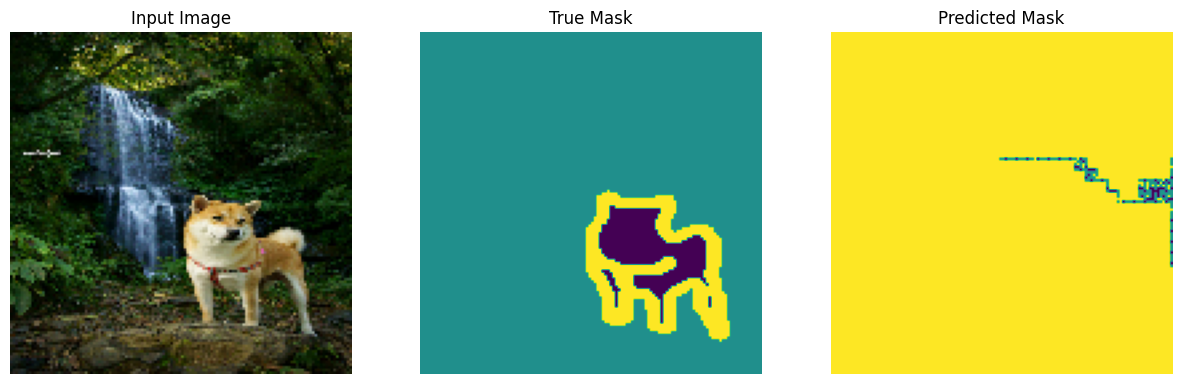

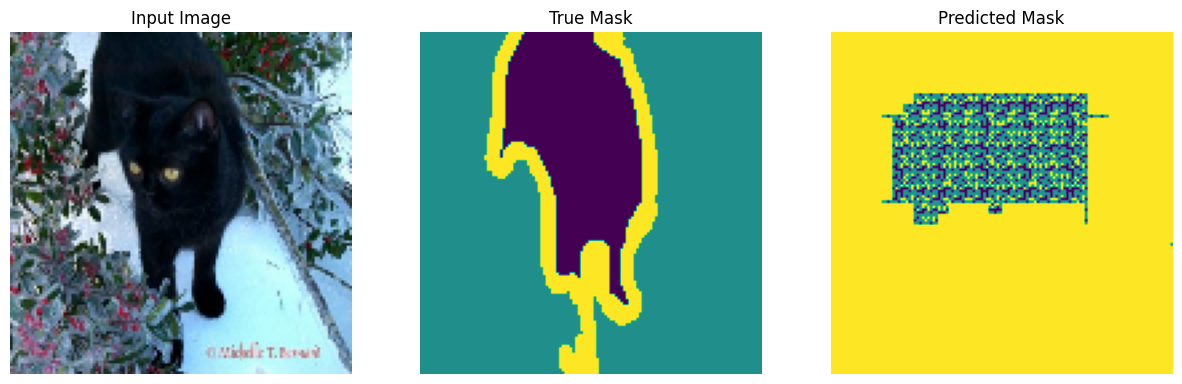

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


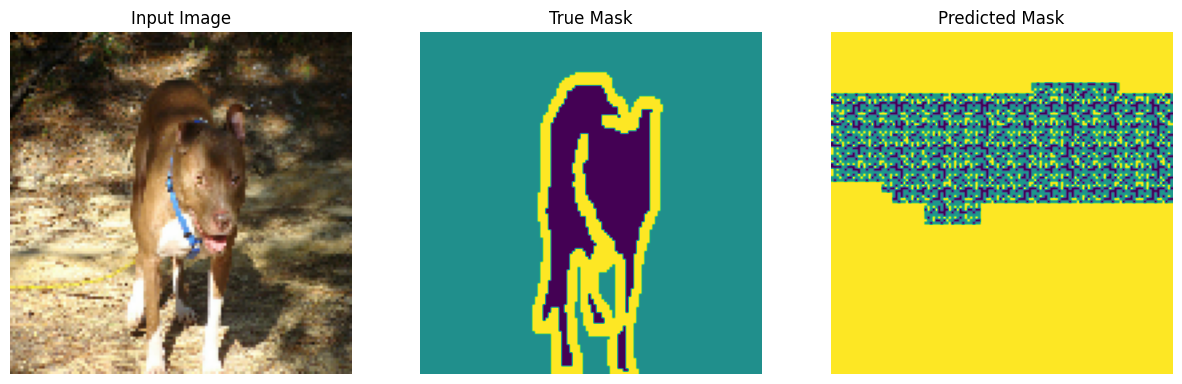

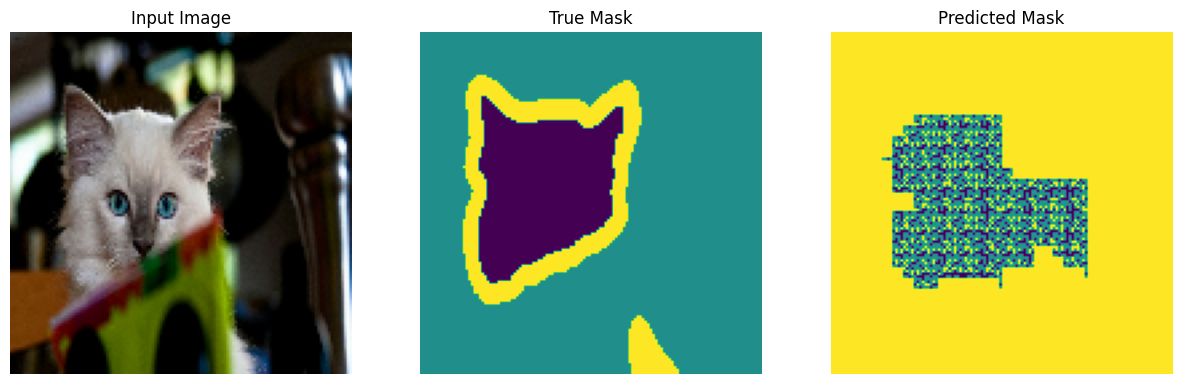

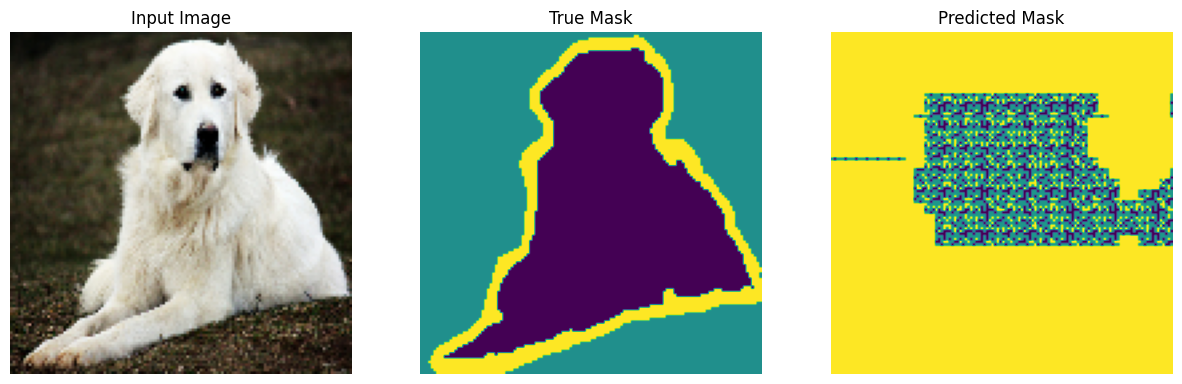

In [ ]:
# Displaying 3 sample predictions from the test dataset
show_predictions(model_pretrained, test_dataset, 3)